In [2]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
from glob import glob 
import random 
import os


In [3]:
data_dir = './20220303/archive' 

In [4]:
paths = '.'
images_path = os.path.join(paths, '20220303', 'archive', 'raw-img')

images = glob(images_path + '/*/*')

In [5]:
RES = 100 
N_CLASS = 10
BATCH_SIZE = 64

# 26179 images 
N_TRAIN = 20000
N_VAL = 6179 

In [6]:
# image = [] 
# label = []
# for img in images: 
#     img = 
#     label = img.split('\\')[-2]

images_ds = tf.keras.preprocessing.image_dataset_from_directory(
    images_path, 
    # validation_split=0.2,
    shuffle=True, 
    image_size=(RES, RES), 
    batch_size=BATCH_SIZE,
    label_mode = 'categorical'
)



Found 26179 files belonging to 10 classes.


In [7]:
def preprocessing(image, label):
    image = tf.cast(image / 255. , tf.float32)
    return image, label

In [8]:
images_ds.unbatch().map(preprocessing).batch(BATCH_SIZE)

<BatchDataset shapes: ((None, 100, 100, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
train_size = int(0.7 * len(images_ds))

train_ds = images_ds.take(train_size)
val_ds = images_ds.skip(train_size)

In [11]:
# images_ds.prefetch(tf.data.AUTOTUNE)
# len(images_ds)
train_ds.prefetch(tf.data.AUTOTUNE)
val_ds.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 100, 100, 3), (None, 10)), types: (tf.float32, tf.float32)>

C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


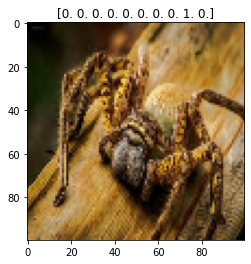

In [12]:
for img, label in images_ds.take(5):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(label[0].numpy()) 
    
plt.show()

In [13]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [14]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 100, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 50, 50, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 50, 50, 16)   64          Conv[0][0]                       
___________________________________________________________________________________

In [15]:
def create_model():
    inputs = tf.keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs) 
    x = mobilenetv3(x) 
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dense(N_CLASS)(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

In [16]:
model = create_model()

In [17]:
model.compile(tf.keras.optimizers.SGD(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])


In [18]:
hist = model.fit(images_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
410/410 [==============================] - 228s 547ms/step - loss: 2.2393 - accuracy: 0.2294 - val_loss: 2.1156 - val_accuracy: 0.2829
Epoch 2/10
410/410 [==============================] - 218s 531ms/step - loss: 1.7423 - accuracy: 0.4111 - val_loss: 1.6395 - val_accuracy: 0.4435
Epoch 3/10
410/410 [==============================] - 209s 509ms/step - loss: 1.5284 - accuracy: 0.5109 - val_loss: 1.4194 - val_accuracy: 0.5464
Epoch 4/10
410/410 [==============================] - 193s 472ms/step - loss: 1.4036 - accuracy: 0.5664 - val_loss: 1.2981 - val_accuracy: 0.6056
Epoch 5/10
410/410 [==============================] - 224s 546ms/step - loss: 1.3164 - accuracy: 0.6060 - val_loss: 1.2224 - val_accuracy: 0.6405
Epoch 6/10
410/410 [==============================] - 222s 541ms/step - loss: 1.2476 - accuracy: 0.6360 - val_loss: 1.1642 - val_accuracy: 0.6646
Epoch 7/10
410/410 [==============================] - 213s 518ms/step - loss: 1.1886 - accuracy: 0.6560 - val_loss: 1.1159 -

In [110]:
def aug(image, label): 
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [111]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [112]:
model = create_model() 

In [113]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy']
              )

In [114]:
hist = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
287/287 [==============================] - 28s 86ms/step - loss: 0.9747 - accuracy: 0.7277 - val_loss: 1.1479 - val_accuracy: 0.6378
Epoch 2/50
287/287 [==============================] - 24s 84ms/step - loss: 0.6114 - accuracy: 0.8410 - val_loss: 1.2149 - val_accuracy: 0.6231
Epoch 3/50
287/287 [==============================] - 24s 85ms/step - loss: 0.4712 - accuracy: 0.8785 - val_loss: 0.9621 - val_accuracy: 0.7173
Epoch 4/50
287/287 [==============================] - 24s 84ms/step - loss: 0.3890 - accuracy: 0.8961 - val_loss: 0.8918 - val_accuracy: 0.7367
Epoch 5/50
287/287 [==============================] - 24s 84ms/step - loss: 0.3270 - accuracy: 0.9119 - val_loss: 0.9334 - val_accuracy: 0.7286
Epoch 6/50
287/287 [==============================] - 25s 85ms/step - loss: 0.2722 - accuracy: 0.9286 - val_loss: 0.8722 - val_accuracy: 0.7506
Epoch 7/50
287/287 [==============================] - 25s 87ms/step - loss: 0.2397 - accuracy: 0.9368 - val_loss: 0.9599 - val_accuracy:

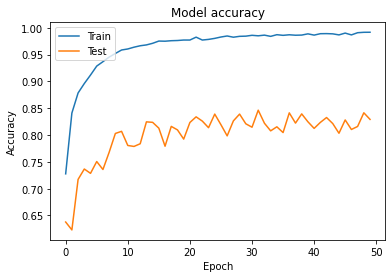

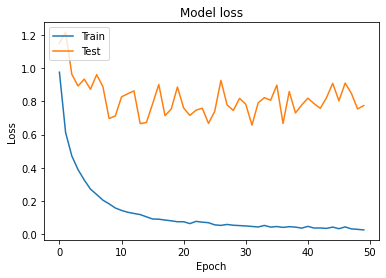

In [115]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()